In [1]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import random
import math

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [2]:
iris = datasets.load_iris()

In [3]:
classification_data, classification_labels = iris.data, iris.target

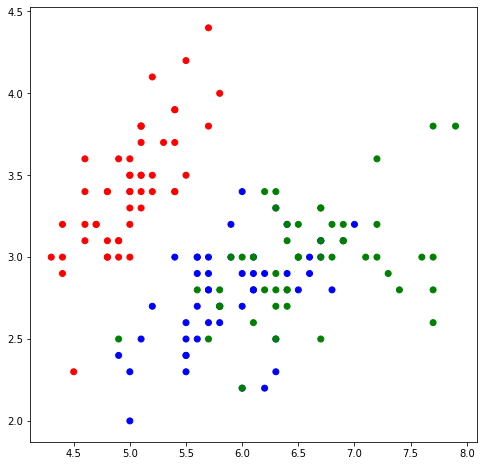

In [4]:
colors = ListedColormap(['red', 'blue', 'green'])
light_colors = ListedColormap(['lightcoral', 'lightblue', 'lightgreen'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [5]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [6]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    subsample = sample_indexes[0:len_subsample].copy()
#     for _ in range(len_subsample):
#         subsample.append(sample_indexes.pop())
        
    return subsample

In [7]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [8]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [9]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [10]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels) # При критерии Джини    

In [11]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [12]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [13]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [14]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [15]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [16]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [17]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [18]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

In [19]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [20]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

1. Обучить любую модель классификации на датасете IRIS до применения PCA и после него. Сравнить качество классификации по отложенной выборке.

Построим лес из трех деревьев

In [21]:
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)

In [22]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_3, train_data)

In [23]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_3, test_data)

In [24]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 94.286


In [25]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 3 деревьев на тестовой выборке: 97.778


In [26]:
X = iris.data

In [27]:
X_ = X.astype(float)

In [28]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
XPCAreduced = pca.fit_transform(X_)

In [29]:
train_data_rca, test_data_rca, train_labels_rca, test_labels_rca = model_selection.train_test_split(XPCAreduced, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [30]:
n_trees = 3
my_forest_3_rca = random_forest(train_data_rca, train_labels_rca, n_trees)

In [31]:
train_answers_rca = tree_vote(my_forest_3_rca, train_data_rca)

In [32]:
test_answers_rca = tree_vote(my_forest_3_rca, test_data_rca)

In [33]:
train_accuracy_rca = accuracy_metric(train_labels_rca, train_answers_rca)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy_rca:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 93.333


In [34]:
test_accuracy_rca = accuracy_metric(test_labels_rca, test_answers_rca)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy_rca:.3f}')

Точность случайного леса из 3 деревьев на тестовой выборке: 93.333


Мы видим небольшое падение точности предсказания при использовании RCA

2*. Написать свою реализацию метода главных компонент с помощью сингулярного разложения с использованием функции numpy.linalg.svd()

In [35]:
def svd(X):
    u, d, vt = np.linalg.svd(X, full_matrices=True)
    W = vt.transpose()[:, :len(d)]
    Z = np.dot(X, W)
    return Z

In [36]:
Z = svd(X_)

In [37]:
Z[:10]

array([[-5.91274714e+00,  2.30203322e+00,  7.40153559e-03,
         3.08770624e-03],
       [-5.57248242e+00,  1.97182599e+00,  2.44592251e-01,
         9.75528883e-02],
       [-5.44697714e+00,  2.09520636e+00,  1.50292625e-02,
         1.80133308e-02],
       [-5.43645948e+00,  1.87038151e+00,  2.05048805e-02,
        -7.84915014e-02],
       [-5.87564494e+00,  2.32829018e+00, -1.10338269e-01,
        -6.07193259e-02],
       [-6.47759822e+00,  2.32464996e+00, -2.37202487e-01,
        -2.14196330e-02],
       [-5.51597520e+00,  2.07090423e+00, -2.29853120e-01,
        -5.04066493e-02],
       [-5.85092859e+00,  2.14807482e+00,  1.87937744e-02,
        -4.53426193e-02],
       [-5.15891972e+00,  1.77506408e+00,  6.10392203e-02,
        -3.11286325e-02],
       [-5.64500117e+00,  1.99000106e+00,  2.24852923e-01,
        -5.74343903e-02]])